# Euclidean Generalized TSP with Biased RKGA: A minimal demo

In [1]:
from gasuite.brkga import Termination_criteria, BRKGA_Population_size, BRKGA_GTSP
from gasuite.problems import geometric_tsp
import numpy as np

from typing import Final
import matplotlib
import matplotlib.pyplot as plt
np.set_printoptions(precision=2)

In [2]:
class GTSP_Problem:
    def __init__(self, clusters_pts : list[np.ndarray], ndim=2):
        for pts_in_cluster in clusters_pts:
            assert pts_in_cluster.ndim == 2
            assert pts_in_cluster.shape[1] == ndim
        
        num_pts_in_clusters = [len(pts_in_cluster) for pts_in_cluster in clusters_pts]
        self._breaks = np.cumsum(np.array([0, *num_pts_in_clusters]))
        
        # all `ndim` points (in a flattened scheme)
        self._all_pts : Final[np.ndarray] = np.vstack(clusters_pts).reshape(-1, ndim)

    @property
    def num_clusters(self) -> int:
        return len(self._breaks) - 1
    
    def get_points_in_cluster(self, which_cluster: int) -> np.ndarray:
        assert 0 <= which_cluster < self.num_clusters
        return self._all_pts[self._breaks[which_cluster]:self._breaks[which_cluster+1], ...]
    def get_num_points_in_cluster(self, which_cluster: int) -> int:
        return self._breaks[which_cluster+1] - self._breaks[which_cluster]
    
    def flatten_hierarchical_pt_idx(self, which_cluster, pt_local_index) -> int:
        assert 0 <= which_cluster < self.num_clusters
        assert 0 <= pt_local_index < self.get_num_points_in_cluster(which_cluster)
        return self._breaks[which_cluster] + pt_local_index
    
    def flatten_hierarchical_pt_idx_batch(self, cluster_seq, which_cities_sorted_by_cluster_Id) -> list[int]:
        which_cities_along_seq = which_cities_sorted_by_cluster_Id[cluster_seq]
        return [self.flatten_hierarchical_pt_idx(p,w) for p,w in zip(cluster_seq, which_cities_along_seq)]
        
    def eval_idlePathLength_by_nestedIndex(self, path_seq, which_entry) -> float:
        """evaluate the total idle path length

        Let `Nc` be the number of clusters, 

        Args:
            path_seq (int[Nc]): the order of paths to travel
            which_entry (int[Nc]): PAY ATTENTION!!!
                `which_entry[i]` = the index of the sample point in contour[ii]
                
        Returns:
            float: the total sum
        """
        assert len(path_seq) == len(which_entry)
        which_entry_along_path = which_entry[path_seq]
        flattened_index = [self.flatten_hierarchical_pt_idx(p,w) for p,w in zip(path_seq, which_entry_along_path)]
        flattened_index.append(flattened_index[0]) # to complete the tour
        return np.sum(np.linalg.norm(np.diff(self._all_pts[flattened_index], axis=0), axis=1))

    def visualize(self, ax: matplotlib.axes.Axes, txtOffset = (0.2, 0.2), c = 'k', **kwargs):
        """
        we don't rely on labels to distinguish the the paths 
        because it can become unmanageable when there are so many paths
        """
        for ii in range(self.num_clusters):
            all_pts_in_this_cluster = self.get_points_in_cluster(ii)
            ax.plot(*all_pts_in_this_cluster.T, c='k', **kwargs)
            startXY = all_pts_in_this_cluster[0]
            ax.annotate(f"Contour {ii}", xy=startXY, xytext=startXY + txtOffset, arrowprops=dict(arrowstyle="->"))
    

In [3]:
clusters = (
    ( # the left square
        (2,1),
        (2,2),
        (2,3),
        (3,3),
        (4,3),
        (4,3),
        (4,2),
        (4,1),
        (3,1)     
    ),
    ( # the bottom hat
        (6,1),
        (7,3),
        (8,1)
    ),
    ( # the right-hand-side G
        (11,5),
        (10,5),
        (9,5),
        (9,4),
        (9,3),
        (10,3),
        (11,3),
        (11,4),
        (10,4)
    ),
    ( # the top quadrilateral
        (8,7),
        (8,6),
        (5,5),
        (6,7)
    )    
)
clusters = [np.array(d, dtype=float) for d in clusters]

prob = GTSP_Problem(clusters)
print(prob._breaks)
for i in range(prob.num_clusters):
    print(prob.get_num_points_in_cluster(i))

[ 0  9 12 21 25]
9
3
9
4


In [4]:
prob.get_points_in_cluster(0)

array([[2., 1.],
       [2., 2.],
       [2., 3.],
       [3., 3.],
       [4., 3.],
       [4., 3.],
       [4., 2.],
       [4., 1.],
       [3., 1.]])

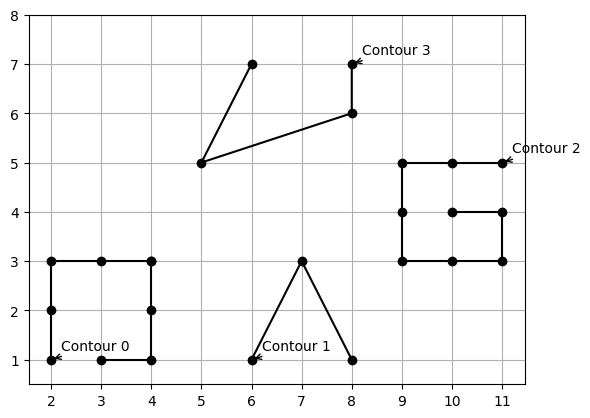

In [5]:
_, ax = plt.subplots()
prob.visualize(ax, ms=6, marker='o')
ax.set_ylim(0.5, 8)
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
plt.grid()
plt.show()

In [6]:
population_cfg = BRKGA_Population_size(total=100, elite = 4, mutant = 25)
print(population_cfg)
print(" ==> number of crossovers:", population_cfg.xover)

term_criteria = Termination_criteria(
    max_num_gen=500, 
    earlyTerm_improvement_convergence=1e-6, 
    earlyTerm_patience=100)

res = BRKGA_GTSP([len(d) for d in clusters], prob.eval_idlePathLength_by_nestedIndex,
                population_cfg, term_criteria, crossover_bias=0.7,
                rng=np.random.default_rng(12345))

print("Solver exited because", res.reason)
allTimeBest_cost = res.cost_stats.get_all_time_best()
print("Final result", res.optimizer)
print("Number of iterations:", res.cost_stats.num_completed_iterations)
print("Cost of the returned solution:", allTimeBest_cost)

# just to be sure the optimizer is reasonable
assert len(res.optimizer[0]) == len(clusters)
# TODO: check if it's a real permutation
assert prob.eval_idlePathLength_by_nestedIndex(*res.optimizer) == res.cost_stats.get_all_time_best()

BRKGA_Population_size(total=100, elite=4, mutant=25)
 ==> number of crossovers: 71
Solver exited because Termination_decision.stop_on_sufficient_cost_convergence
Final result (array([3, 2, 1, 0]), array([5, 1, 3, 2]))
Number of iterations: 103
Cost of the returned solution: 11.595241580617241


Remarks: 
* The functions in `geometric_tsp` also support Manhattan, and max/inf-norms
* Try run it again several time (wit
h different seeds), you will probably find the optimal solution very soon.
* You can also define your own cost function very easily, e.g., for "open TSP"

## Learning curve

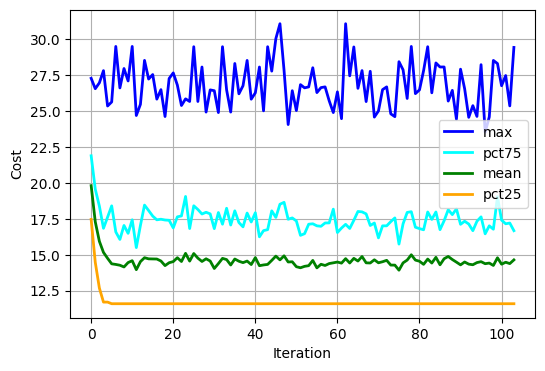

In [7]:
_, ax = plt.subplots(figsize=(6,4))
res.cost_stats.visualize_learning_curve(ax, lw=2)
plt.show()

## The computed tour

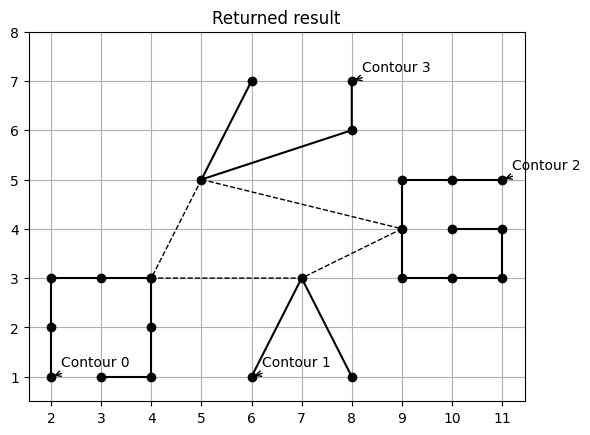

In [8]:
# the tour
_ , ax = plt.subplots()
flatten_pt_indices = prob.flatten_hierarchical_pt_idx_batch(*res.optimizer)
flatten_pt_indices.append(flatten_pt_indices[0]) # close the loop
path_xy = prob._all_pts[flatten_pt_indices]
ax.plot(*path_xy.T, '--ok', label="Computed", lw=1, ms=4)

prob.visualize(ax, ms=6, marker='o')
ax.set_title("Returned result")
ax.set_ylim(0.5, 8)
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
plt.grid()
plt.show()